<a href="https://colab.research.google.com/github/AdamCorbinFAUPhD/Fairness/blob/main/ITA_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In this colab we will go over what it takes to generate individual typology angle (ITA) values which were developed in this [paper](https://link.springer.com/chapter/10.1007/978-3-030-59725-2_31?error=cookies_not_supported&code=a61140d1-db8d-4cf8-8d67-a63e1c976380)

The ITA values represent 7 different levels of skin tones

|ITA Range| Skin Tone Category|Abbreviation|
|--|--|--|
|55$^\circ$ $\lt$ ITA|Very Light|very_lt|
|48$^\circ$ $\lt$ ITA $\leq$ 55$^\circ$ |Light 2|lt2|
|41$^\circ$ $\lt$ ITA $\leq$ 48$^\circ$|Light 1|lt1|
|34.5$^\circ$ $\lt$ ITA $\leq$ 41$^\circ$|Intermediate 2|int2|
|28$^\circ$ $\lt$ ITA $\leq$ 34.5$^\circ$|Intermediate 1|int1|
|19$^\circ$ $\lt$ ITA $\leq$ 28$^\circ$|Tanned 2|tan2|
|10$^\circ$ $\lt$ ITA $\leq$ 19$^\circ$|Tanned 1|tan1|
|ITA $\leq$ 10$^\circ$|Dark|dark|

The ITA uses the following equation

ITA$ = archtan \left(\frac{L - 50}{b} \right) \times \frac{180^\circ}{\pi}$

where $L$ is luminance and $b$ is amount of yellow


The main 3 experiments that are going to be covered here are as follows
1. Collect the ITA values of the whole images
2. Collect the ITA values of the cut out potion of the mask from the images
3. Collect the ITA values of ~100 patches around the boarder of the image

These results will then be compared against each other. The masked should be the ground truth since thats removing the skin lesion from the image giving a better representation for the ITA value. Then we will compare the ground truth to the 100 patches to see how well it preformed against the "ground truth"




# Setup & Get images

## Constants 

In [ ]:
BORDER_REMOVAL_SIZE = 4
PATCH_WIDTH = 8
PATCH_HEIGHT = 8

## Installs & Imports

### install

In [ ]:
!pip install patchify

### Imports

In [ ]:
import random
import os
import io
import numpy as np 
import pandas as pd 
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix

from patchify import patchify
from pathlib import Path

import tensorflow as tf, re, math
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import skimage
import cv2
from skimage import color


AUTO = tf.data.experimental.AUTOTUNE
random.seed(42)
rng = np.random.default_rng(seed=42)




## Download Images

In [ ]:
!git clone https://github.com/manideep2510/melanoma_segmentation.git

Cloning into 'melanoma_segmentation'...
remote: Enumerating objects: 5578, done.
remote: Total 5578 (delta 0), reused 0 (delta 0), pack-reused 5578
Receiving objects: 100% (5578/5578), 101.46 MiB | 31.57 MiB/s, done.
Resolving deltas: 100% (464/464), done.
Checking out files: 100% (5509/5509), done.


# Organize images into a dataset

## Read all images from test, train and validation

In [ ]:
"""
This section we read all the images including their masks. 
Since we are just using this to test the ITA values we can join 
the test, train and validation sets
"""

orig_images = []
masks_images = []
folders_to_search = ["test","train","validation"]


for folder in folders_to_search:
    for file in Path(f"melanoma_segmentation/{folder}x").glob("*.jpg"):        
        orig_images.append(file)

    for file in Path(f"melanoma_segmentation/{folder}y").glob("*.jpg"):
        masks_images.append(file)


print(len(orig_images))
print(len(masks_images))


2750
2750


In [ ]:
def strip_filename(file):
    """
    This function makes an identifier that matches between both the base image and the masked image
    """

    fn = file.name.replace("imgx","")
    fn = fn.replace("imgy","")
    path = file.parent.parts[-1].replace("x","").replace("y","")
    uuid = f"{path}/{fn}"
    return uuid

In [ ]:
def create_masked_image(image, mask):
    
    orig_image = Image.open(io.BytesIO(image))
    imgpx = np.array(orig_image)

    mask_bytes = io.BytesIO(mask)
    mask = Image.open(mask_bytes)
    mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 
    mask_pix = np.array(mask)    

    # Adding the mask to the image 
    image_masked = np.where(mask_pix[...,None], imgpx,0)
    im_byte_array = Image.fromarray(image_masked)

    # Saving the masked image to a byte array
    img_byte_arr = io.BytesIO()
    orig_image = im_byte_array.convert('RGB')
    orig_image.save(img_byte_arr, format="JPEG")
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

## Create dataframe with images and masks

In [ ]:
dict_data = {}
data_list = []
for file in orig_images:    
    dict_data[strip_filename(file)] = file

for file in masks_images:
    # Adding the previous image to the new item so it will include both mask and iamge    
    image = open(dict_data[strip_filename(file)],"rb").read()    
    mask = open(file,"rb").read()

    # now to cut the mask out of the image
    masked_image = create_masked_image(image, mask)
    data_list.append([strip_filename(file), image, mask, masked_image ])
    

# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["ID","image", "mask", "masked_image"])



### Display dataframe item and images

ID                                                    test/52.jpg
image           b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
mask            b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
masked_image    b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
Name: 4, dtype: object
Shape of image:  (192, 256, 3)


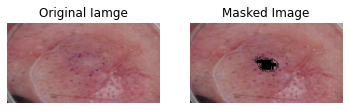

In [ ]:
index = 4
item = df.iloc[index] 
print(item)
mask = item["mask"]
image = item["image"]
img = io.BytesIO(mask)
mask = Image.open(img)
mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion 

orig_image = Image.open(io.BytesIO(image))
pix = np.array(mask)
imgpx = np.array(orig_image)
image_masked = np.where(pix[...,None], imgpx,0)
print("Shape of image: ", imgpx.shape)

im = Image.fromarray(image_masked)


ax = plt.subplot(1, 2, 1)
image = Image.open(io.BytesIO(item["image"]))
plt.imshow(image,aspect=.7)
plt.title("Original Iamge")
plt.axis("off")
plt.subplots_adjust(hspace = .5)

ax = plt.subplot(1, 2,2)
image = Image.open(io.BytesIO(item["masked_image"]))
plt.imshow(image,aspect=.7)
plt.title("Masked Image")
plt.axis("off")
plt.subplots_adjust(hspace = .5)


# ITA experiments

## Compute the ITA value for each image

This section is a simple ITA computation on the images that are masked and unmasked

In [ ]:
def compute_ita_from_lab(lab):
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:,:,0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)
    
    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)
        
    b = lab[:,:,2]
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)


    ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)
    return ita

In [ ]:
def compute_ita(image):
    img = io.BytesIO(image)
    pilimae = Image.open(img)        
    lab = np.array(skimage.color.rgb2lab(pilimae))
    return compute_ita_from_lab(lab)


In [ ]:
df["ITA_masked"] = df["masked_image"].apply(compute_ita)
df["ITA_orig"] = df["image"].apply(compute_ita)

##Patches experiments

 ### Utils - creating patches from image

In [ ]:
def format_image_and_get_patches(image):
    img = io.BytesIO(image)
    pil_image = Image.open(img) 

    # Crop image to remove the pixels from the boarder
    w, h = pil_image.size
    
    cropped_area = (BORDER_REMOVAL_SIZE,BORDER_REMOVAL_SIZE,w - BORDER_REMOVAL_SIZE, h - BORDER_REMOVAL_SIZE)
    cropped_image = pil_image.crop(cropped_area)


    #print("pil_image", np.array(pil_image).shape)
    #print("cropped_image", np.array(cropped_image).shape)
    # Convert image to lab values
    lab = np.array(skimage.color.rgb2lab(cropped_image))

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=8)

### ITA on all patches

In [ ]:
def get_ita_for_all_patches(image):
    patches = format_image_and_get_patches(image)
    # Capture all the ITA values for each patch. 
    ita_values = []
    for x, x_item in enumerate(patches):
        for y, y_item in enumerate(patches[x]):        
            patch = patches[x][y][0]        
            ita_values.append(compute_ita_from_lab(patch))  
    return ita_values

### Cropped center

In [ ]:
def get_cropped_center_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values.
    """
    patches = format_image_and_get_patches(image)

    center_removal_percentage = .70 / 2
    w = len(patches)
    h = len(patches[0])

    w_offset = int(w * center_removal_percentage)
    h_offset = int(h * center_removal_percentage)

    w_mid = int(w/2)
    h_mid = int(h/2)

    indices = []

    #print("Will ignore values in these ranges")
    #print(f"{w_mid - w_offset} < x < {w_mid + w_offset} and {h_mid - h_offset} < y < {h_mid + h_offset}")
    selected_ita_values = []
    for x, x_item in enumerate(patches):
        for y, y_item in enumerate(patches[x]):
            if w_mid - w_offset <= x <= w_mid + w_offset and h_mid - h_offset <= y <= h_mid + h_offset:
                continue
            patch = patches[x][y][0]        
            selected_ita_values.append(compute_ita_from_lab(patch)) 
            indices.append([x,y])
    
    return selected_ita_values, indices

In [ ]:
def get_cropped_center_ita(row):
    """
    Note we want to ignore the center part of the images. We will take 15% around the center of the image and ignore getting the ITA
    values for those images. Taking 15% of the width and height will get offset value. Then dividing the width and height by 2
    will be the mid-point which we can take the offset and do a +- to get a range where we dont want to capture the ITA values
    as long as the x and y indexes dont fall between both ranges then we will capture the ITA values of the image.

    """

    image = row["image"]
    ita_values, indices = get_cropped_center_patches_ita_list(image)
    row["ITA_center_cropped"] = np.median(ita_values)
    row["ITA_center_cropped_indices"] = indices
    return row 

### Structured Patches

Creating masks can be difficult to obtain from either working with medical professionals to generate the masks or even developing an AI segmentation solution to generate the masks. In this alternate approach the idea would be to take small patches around the boarder of the image. The center of the image will not be sampled as we are assuming that skin lesion will be around that potion of the image. Also the absolute boarder will be also ignored with an assumption that there might be some bad artifacts around the boarder that would not represent the skin tones.

In [ ]:
def get_structured_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be 
    sampled for the ITA values. When taking the boarder we need ot make sure the corners are not double counted
    """
    patches = format_image_and_get_patches(image)

    selected_ita_values = []

    row_count = len(patches)
    col_count = len(patches[0])
    

    indices = []
    # First row
    for i, patch in enumerate(patches[0]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([0,i])
    # last row
    for i, patch in enumerate(patches[-1]):        
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([row_count - 1,i])
    # First column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][0]
        selected_ita_values.append(compute_ita_from_lab(patch[0])) 
        indices.append([i,0])

    # Last column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][-1]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,col_count-1])


    return selected_ita_values, indices

In [ ]:
def get_structured_patches_ita(row):
 
    image = row["image"]
    ita_values, indices = get_structured_patches_ita_list(image)
    row["ITA_structured_patches"] = np.median(ita_values)
    row["ITA_structured_patches_indices"] = indices

    return row

#### Testing 1 image

In [ ]:
ita, coords = get_structured_patches_ita_list(df.iloc[0]["image"])

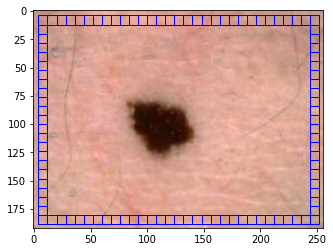

In [ ]:
img = io.BytesIO(df.iloc[0]["image"])

im = Image.open(img)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for coord in coords:
    # Create a Rectangle patch    
    x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
    y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
    rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

### Random patches

In [ ]:
percent_of_random_patches = .21
# randomly pick numbers between 0 and max patches
def get_random_patches_ita_list(image, verbose=False):
    """
    The premise behind random patches is that a set of patches that do not overlap a generated and at random patches 
    be sampled to take the ITA value from. The thought would be that because its a random sample that the majority should
    cover or represent the skin tone. It is possible that some of the patches could cover a skin lesion which will be address in 
    a future approach.
    """
    patches = format_image_and_get_patches(image)
    row_count = len(patches)
    column_count = len(patches[0])
    
    patch_count = row_count * column_count
    
    random_to_select = int(patch_count * percent_of_random_patches)
    
    # Generate a random list of numbers with no duplicates
    random_patch_indexes = rng.choice(patch_count, size=random_to_select, replace=False)
    random_patch_indexes.sort()
    
    # get reverse indexes. The index number comes from nRow * col_count + nCol. 
    # so for example if you have 10x10 image. image index 23 is row 2 col 4. The formula would be 2*10 + 4 = 24
    # x = number % column_count
    # y = int(number / column_count) 
    
    coordinate_indices = []
    for index in random_patch_indexes:
        y = index % column_count
        x = int(index /column_count)
        coordinate_indices.append([x,y])
    if verbose:
        print(f"row_count {row_count} column_count {column_count} ")
        print(f"patch_count {patch_count}, random_to_select {random_to_select}")
        print(f"random_patch_indexes\n{random_patch_indexes}")
        print(f"coordinate_indices\n{coordinate_indices}")

    ita_values = []
    for index in coordinate_indices:
        x = index[1]
        y = index[0]
        patch = patches[y][x]
        ita_values.append(compute_ita_from_lab(patch[0]))
    return ita_values, coordinate_indices



In [ ]:
def get_random_patches_ita(row):

    image = row["image"]
    
    ita_values, indices = get_random_patches_ita_list(image)
    row["ITA_random_patches"] = np.median(ita_values)
    row["ITA_random_patches_indices"] = indices
    return row

#### Testing 1 image

In [ ]:
ita, coords = get_random_patches_ita_list(df.iloc[0]["image"],verbose=True)

row_count 23 column_count 31 
patch_count 713, random_to_select 142
random_patch_indexes
[  4  21  25  27  38  41  48  49  51  54  55  63  75  79  83  93  96  97
 101 105 108 116 121 134 137 147 152 160 168 169 188 192 205 207 213 214
 218 219 227 232 236 240 246 249 252 257 261 266 271 275 285 288 291 296
 298 300 301 304 306 307 310 311 314 320 327 335 343 346 366 375 380 384
 385 389 390 393 394 396 402 403 413 420 426 429 430 431 436 443 444 445
 451 454 456 460 461 463 464 465 468 471 472 480 483 492 495 504 506 510
 521 529 532 533 534 538 542 545 550 551 552 558 559 561 568 577 583 589
 595 598 600 613 614 619 642 645 665 675 682 694 697 699 703 707]
coordinate_indices
[[0, 4], [0, 21], [0, 25], [0, 27], [1, 7], [1, 10], [1, 17], [1, 18], [1, 20], [1, 23], [1, 24], [2, 1], [2, 13], [2, 17], [2, 21], [3, 0], [3, 3], [3, 4], [3, 8], [3, 12], [3, 15], [3, 23], [3, 28], [4, 10], [4, 13], [4, 23], [4, 28], [5, 5], [5, 13], [5, 14], [6, 2], [6, 6], [6, 19], [6, 21], [6, 27], [6, 28], 

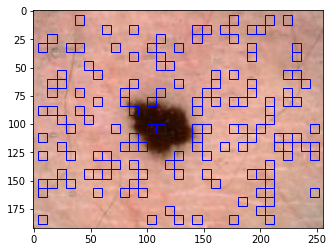

In [ ]:
# display image, 
# add rectangles on each of the patches

img = io.BytesIO(df.iloc[0]["image"])

im = Image.open(img)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for coord in coords:
    # Create a Rectangle patch    
    x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
    y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE
    rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

### Smart Random patches

In [ ]:
percent_of_random_patches = .20
# Randomly pick a patch and test using a fitness test


### Evaluating 1 image

In [ ]:
orig_ita_values = get_ita_for_all_patches(df.iloc[0]["image"])
cropped_center_values = get_cropped_center_patches_ita_list(df.iloc[0]["image"])[0]
structured_ita_values = get_structured_patches_ita_list(df.iloc[0]["image"])[0]
random_ita_values = get_random_patches_ita_list(df.iloc[0]["image"])[0]

In [ ]:
print('displaying the number of patches per method')
print(f"|{'Method':20}|{'Count':^10}|{'Total %':^4}|")
print(f"|{'All patches':20}|{len(orig_ita_values):^10}|{len(orig_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Cropped Center':20}|{len(cropped_center_values):^10}|{len(cropped_center_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Structured Patches':20}|{len(structured_ita_values):^10}|{len(structured_ita_values)/len(orig_ita_values)*100:^3.3f}|")
print(f"|{'Random Patches':20}|{len(random_ita_values):^10}|{len(random_ita_values)/len(orig_ita_values)*100:^3.3f}|")


displaying the number of patches per method
|Method              |  Count   |Total %|
|All patches         |   713    |100.000|
|Cropped Center      |   356    |49.930|
|Structured Patches  |   104    |14.586|
|Random Patches      |   142    |19.916|


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

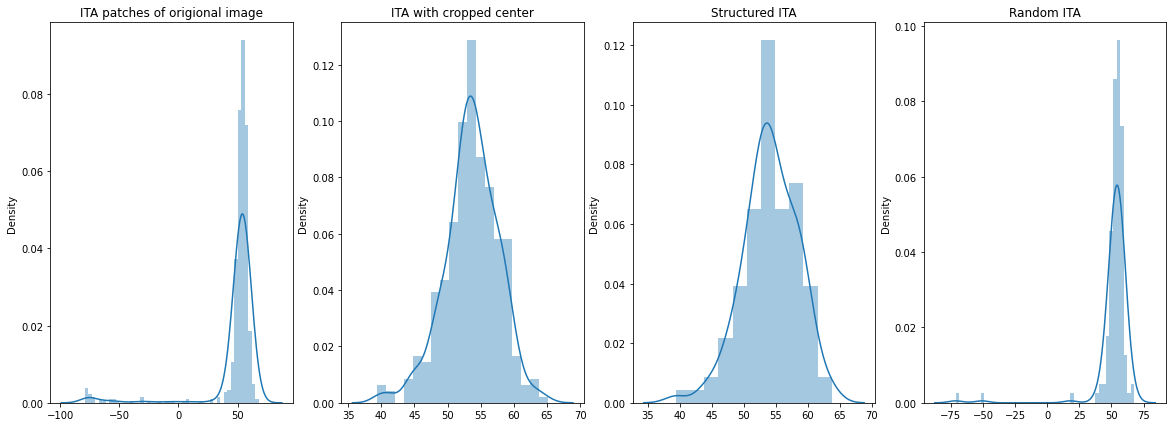

In [ ]:
f, axes = plt.subplots(1, 4)
f.set_size_inches(20,7)


ax = sns.distplot(orig_ita_values,ax=axes[0]).set_title("ITA patches of Original image")
ax = sns.distplot(cropped_center_values,ax=axes[1]).set_title("ITA with cropped center")
ax = sns.distplot(structured_ita_values,ax=axes[2]).set_title("Structured ITA")
ax = sns.distplot(random_ita_values,ax=axes[3]).set_title("Random ITA")

### Calculate ITA on all images using following methods

1. Cropped center
2. Structured approach
3. Random patches
4. Smart Random

In [ ]:
df = df.apply(get_cropped_center_ita, axis=1)
df = df.apply(get_structured_patches_ita, axis=1)
df = df.apply(get_random_patches_ita, axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


## Add the ITA category to the dataframe

In [ ]:
def add_ita_category(ita):
    if ita <= 10:
        return "dark"
    elif 10 < ita <= 19:
        return "tan1"
    elif 19 < ita <= 28:
        return "tan2"
    elif 28 < ita <= 34.5:
        return "int1"
    elif 34.5 < ita <= 41:
        return "int2"
    elif 41 < ita <= 48:
        return "lt1"
    elif 48 < ita <= 55:
        return "lt2"
    elif 55 < ita:
        return "very_lt"

In [ ]:
df["ITA_orig_category"] = df["ITA_orig"].apply(add_ita_category)
df["ITA_masked_category"] = df["ITA_masked"].apply(add_ita_category)
df["ITA_center_cropped_category"] = df["ITA_center_cropped"].apply(add_ita_category)
df["ITA_structured_patches_category"] = df["ITA_structured_patches"].apply(add_ita_category)
df["ITA_random_patches_category"] = df["ITA_random_patches"].apply(add_ita_category)


# Display images with ITA values along with Lab values

This initial display of images was to get a rough feel to see how the ITA values aligned up with a small sample of images. The ITA values seem to do a decent job a representing the skin tones but there ware a few that seem off such as row 0 col 3. This image is classified as a dark skin tone with an ITA value of 8.56. I think the subject of the image is swinging the ITA value lower than if it was segmented out.

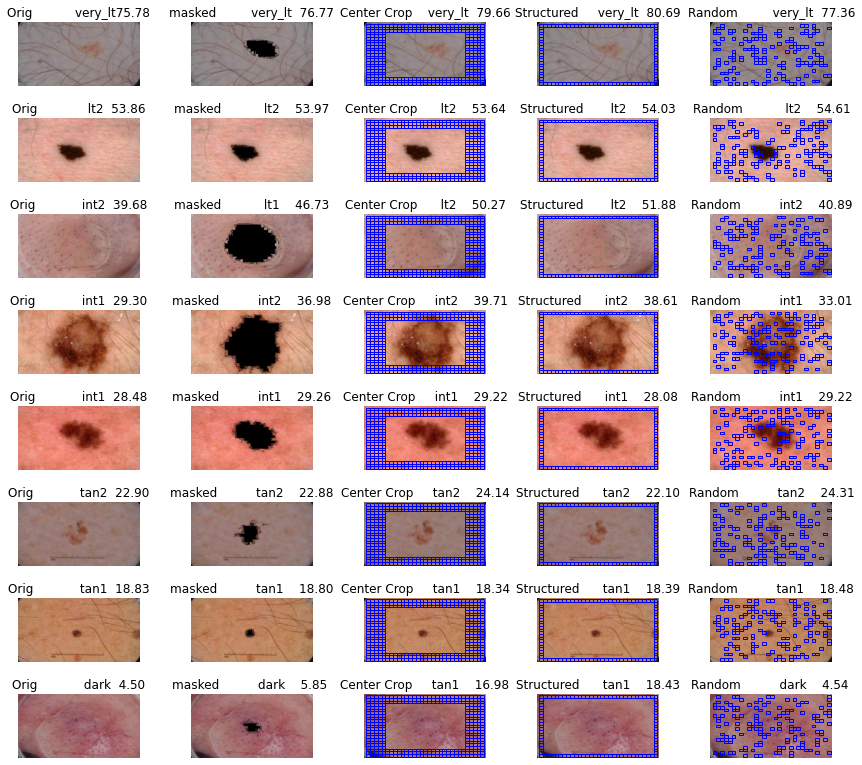

In [ ]:
ITA_Categories_list = ["dark", "tan1", "tan2", "int1", "int2", "lt1", "lt2", "very_lt"]
ITA_Categories_list.reverse()
        
plt.figure(figsize=(15, 70))
index = 0
display_image_count = 1
col_count = 5
for cat in ITA_Categories_list:
    cat_df = df[df["ITA_masked_category"] == cat]
    #print(cat_df.head())
    for ele in cat_df.head(display_image_count).iterrows():
        #print(ele[1])
        
        # Original
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)     
           
        title = f"{'Orig':15}{ele[1]['ITA_orig_category']:^7}{ele[1]['ITA_orig']:^3.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)        
        index += 1

        # Masked
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["masked_image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'masked':15}{ele[1]['ITA_masked_category']:^7}  {ele[1]['ITA_masked']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        index += 1

        # Center cropped
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Center Crop':15}{ele[1]['ITA_center_cropped_category']:^7}  {ele[1]['ITA_center_cropped']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)            
        coords = ele[1]["ITA_center_cropped_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Structured
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Structured':15}{ele[1]['ITA_structured_patches_category']:^7}  {ele[1]['ITA_structured_patches']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1]["ITA_structured_patches_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1

        # Random
        ax = plt.subplot(8*col_count, col_count, index + 1)
        img = io.BytesIO(ele[1]["image"])
        plt.imshow(Image.open(img),aspect=.7)        
        title = f"{'Random':15}{ele[1]['ITA_random_patches_category']:^7}  {ele[1]['ITA_random_patches']:^5.2f}"
        plt.title(title)
        plt.axis("off")
        plt.subplots_adjust(hspace = .5)
        coords = ele[1]["ITA_random_patches_indices"]
        for coord in coords:
            # Create a Rectangle patch    
            x = coord[0] * PATCH_WIDTH + BORDER_REMOVAL_SIZE
            y = int(coord[1] * PATCH_WIDTH) + BORDER_REMOVAL_SIZE    
            rect = patches.Rectangle((y, x), PATCH_HEIGHT, PATCH_WIDTH, linewidth=1, edgecolor='b', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
        index += 1


        #TODO - create columns for smart random


# Evaluate ITA

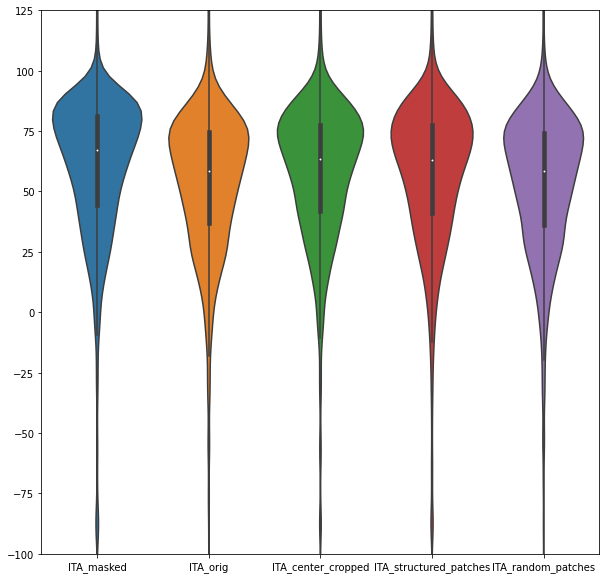

In [ ]:
plt.figure(figsize=(10, 10))
plt.ylim(-100,125)
sns.violinplot(data=df)


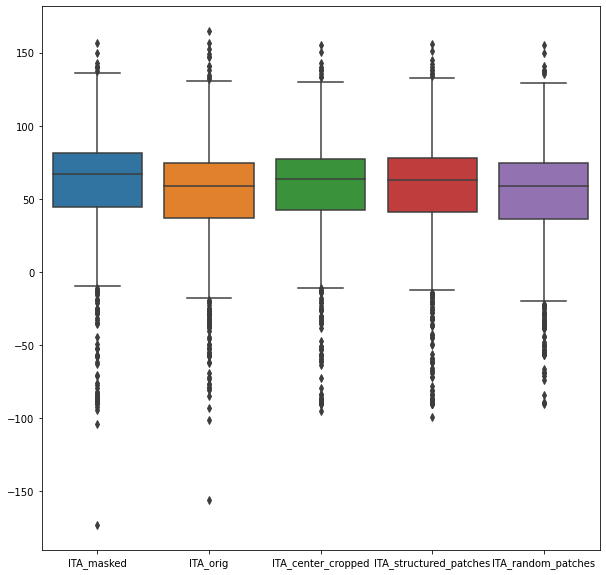

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


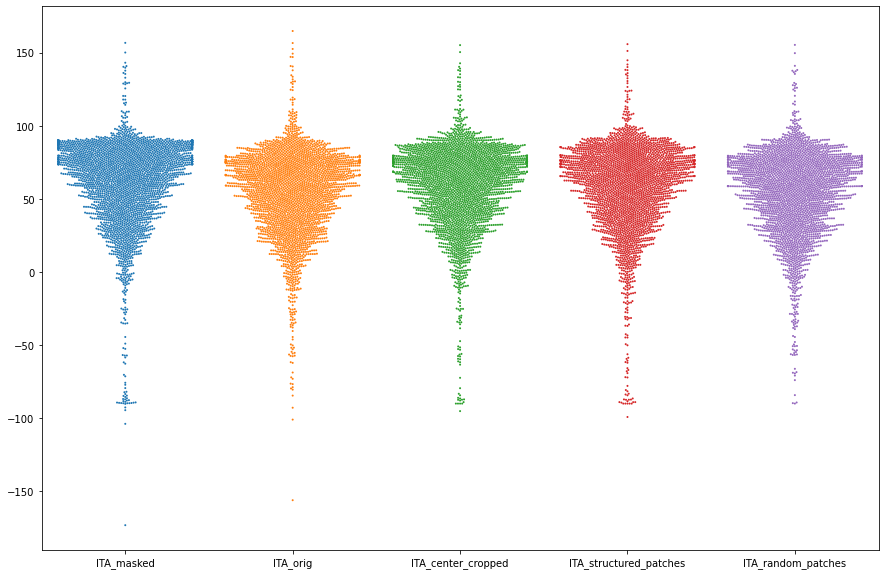

In [ ]:
plt.figure(figsize=(15, 10))
sns.swarmplot(data=df, s=2)

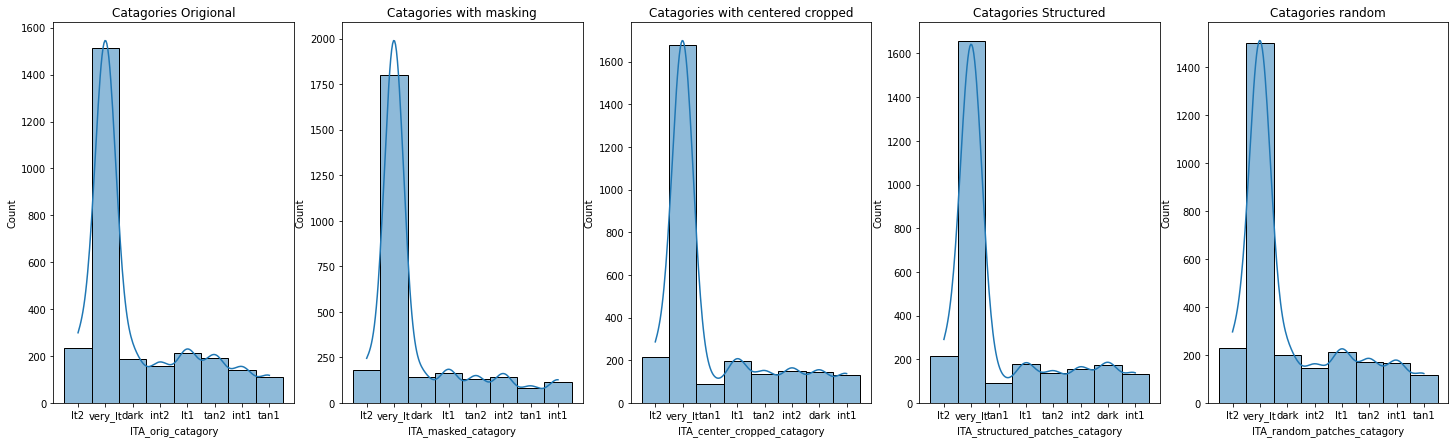

In [ ]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(25,7)

ax = sns.histplot(df.ITA_orig_category,kde=True,ax=axes[0]).set_title("Categories Original")
ax = sns.histplot(df.ITA_masked_category,kde=True,ax=axes[1]).set_title("Categories with masking")
ax = sns.histplot(df.ITA_center_cropped_category,kde=True,ax=axes[2]).set_title("Categories with centered cropped")
ax = sns.histplot(df.ITA_structured_patches_category,kde=True,ax=axes[3]).set_title("Categories Structured")
ax = sns.histplot(df.ITA_random_patches_category,kde=True,ax=axes[4]).set_title("Categories random")

## Performance metrics

Table 3: Evaluation metrics of skin tone predictions compared to manually annotated ground-truth. Metrics are  MAE: mean absolute error;
MSE: mean squared error; and rMSE: root mean squared
error.

Here is a list of other metrics we can look at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [ ]:
# evaluating using mean squared error
# as part of the ITA calculation some rows could not compute the ITA value. 
# We will do some preprocess to drop those rows



original_mse = mean_squared_error(df.ITA_masked, df.ITA_orig)
original_rmse = mean_squared_error(df.ITA_masked, df.ITA_orig, squared=False)
original_mae = mean_absolute_error(df.ITA_masked, df.ITA_orig)
  
center_drop_indexes =  np.where(np.isnan(df.ITA_center_cropped))[0]
df_masked_updated = df.ITA_masked.drop(center_drop_indexes)
df_centered_updated = df.ITA_center_cropped.drop(center_drop_indexes)
center_cropped_mse = mean_squared_error(df_masked_updated, df_centered_updated)
center_cropped_rmse = mean_squared_error(df_masked_updated, df_centered_updated, squared=False)
center_cropped_mae = mean_absolute_error(df_masked_updated, df_centered_updated)


structured_drop_indexes =  np.where(np.isnan(df.ITA_structured_patches))[0]
df_masked_updated = df.ITA_masked.drop(structured_drop_indexes)
df_structured_updated = df.ITA_structured_patches.drop(structured_drop_indexes)
structured_mse = mean_squared_error(df_masked_updated, df_structured_updated)
structured_rmse = mean_squared_error(df_masked_updated, df_structured_updated, squared=False)
structured_mae = mean_absolute_error(df_masked_updated, df_structured_updated)

random_drop_indexes =  np.where(np.isnan(df.ITA_random_patches))[0]
df_masked_updated = df.ITA_masked.drop(random_drop_indexes)
df_random_updated = df.ITA_random_patches.drop(random_drop_indexes)
random_mse = mean_squared_error(df_masked_updated, df_random_updated)
random_rmse = mean_squared_error(df_masked_updated, df_random_updated, squared=False)
random_mae = mean_absolute_error(df_masked_updated, df_random_updated)


print(f"|{'Approach':20}|{'Mean Squared Error':^20}|{'Mean Absolute Error':^20}|{'Root Mean Squared Error':^23}|")
print(f"|{'Original':20}|{original_mse:^20.3f}|{original_mae:^20.3f}|{original_rmse:^23.3f}|")
print(f"|{'Centered Cropped':20}|{center_cropped_mse:^20.3f}|{center_cropped_mae:^20.3f}|{center_cropped_rmse:^23.3f}|")
print(f"|{'Structured Patches':20}|{structured_mse:^20.3f}|{structured_mae:^20.3f}|{structured_rmse:^23.3f}|")
print(f"|{'Random Patches':20}|{random_mse:^20.3f}|{random_mae:^20.3f}|{random_rmse:^23.3f}|")


|Approach            | Mean Squared Error |Mean Absolute Error |Root Mean Squared Error|
|Original            |      444.676       |       8.220        |        21.087         |
|Centered Cropped    |      275.533       |       5.787        |        16.599         |
|Structured Patches  |      304.208       |       7.125        |        17.442         |
|Random Patches      |      479.517       |       8.879        |        21.898         |


## Confusion matrix of labels

Text(0.5, 68.09375000000009, 'Predicted label')

<Figure size 1008x1008 with 0 Axes>

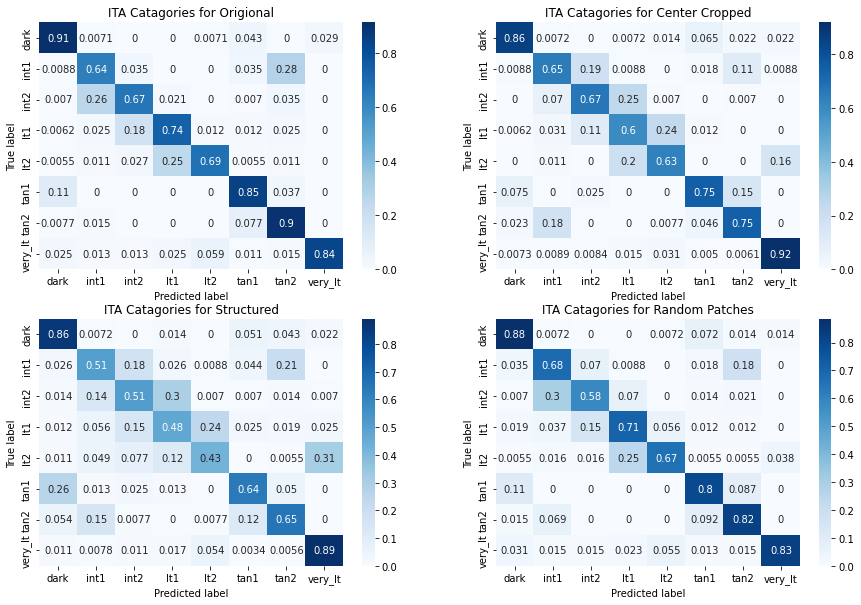

In [ ]:
plt.figure(figsize=(14, 14))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
# orig
cm = confusion_matrix(df.ITA_masked_category,df.ITA_orig_category,normalize="true")
df_cm = pd.DataFrame(cm,columns=np.unique(df.ITA_masked_category.to_numpy()),index=np.unique(df.ITA_masked_category.to_numpy()))
ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[0,0])
ax.set_title("ITA Categories for Original")
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Centered cropped
df_masked_category_updated = df.ITA_masked_category.drop(center_drop_indexes)
df_centered_category_updated = df.ITA_center_cropped_category.drop(center_drop_indexes)
cm = confusion_matrix(df_masked_category_updated,df_centered_category_updated,normalize="true")
df_cm = pd.DataFrame(cm,columns=np.unique(df_masked_category_updated.to_numpy()),index=np.unique(df_masked_category_updated.to_numpy()))
ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[0,1])
ax.set_title("ITA Categories for Center Cropped")
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Structured
df_masked_category_updated = df.ITA_masked_category.drop(structured_drop_indexes)
df_structured_category_updated = df.ITA_structured_patches_category.drop(structured_drop_indexes)
cm = confusion_matrix(df_masked_category_updated,df_structured_category_updated,normalize="true")
df_cm = pd.DataFrame(cm,columns=np.unique(df_masked_category_updated.to_numpy()),index=np.unique(df_masked_category_updated.to_numpy()))
ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[1,0])
ax.set_title("ITA Categories for Structured")
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Random patches
df_masked_category_updated = df.ITA_masked_category.drop(random_drop_indexes)
df_random_category_updated = df.ITA_random_patches_category.drop(random_drop_indexes)
cm = confusion_matrix(df_masked_category_updated,df_random_category_updated,normalize="true")
df_cm = pd.DataFrame(cm,columns=np.unique(df_masked_category_updated.to_numpy()),index=np.unique(df_masked_category_updated.to_numpy()))
ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[1,1])
ax.set_title("ITA Categories for Random Patches")
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')





In [ ]:
cm

array([[ 128,    1,    0,    0,    1,    6,    0,    4],
       [   1,   73,    4,    0,    0,    4,   32,    0],
       [   1,   37,   95,    3,    0,    1,    5,    0],
       [   1,    4,   29,  120,    2,    2,    4,    0],
       [   1,    2,    5,   46,  126,    1,    2,    0],
       [   9,    0,    0,    0,    0,   68,    3,    0],
       [   1,    2,    0,    0,    0,   10,  117,    0],
       [  45,   23,   24,   45,  106,   19,   27, 1510]])